## Contruct gradients only within NPC mask

* get average NPC mask (L&R),
* get square NPC-CM from original CM (fsaverga5) with NPC-mask by
    * take only rows within mask & multiply them with themselves (dot product = covariance matrix)
    * apply mask to rows and columns (cm-subset)
* fit GM to covariance matrix
    * sparsity? influences data point distribution in gradient coordinate system & lambdas!
* plot on brain surface (regions outside mask grey (nans))

### Between group statistics (on subject NPC-GMs)
loop to fit ind. NPC-GMs aligned to average from above in 'loop_NPCmask-gradient_plots.py'
* Group differences via TTest on ind. grad loadings
* gradient dispersion/eccentricity ? (find something similar to visual -to- dorsal-attention being more segregated in dyscalculia from whole brain GM stuff)


#### Additional
* example loop over subs in 'loop_NPCmask-gradient_plots.py' executabel in terminal (tmux)
* mask fsavtofsav5


In [5]:
import numpy as np
import nibabel as nib
from nilearn import datasets
import os.path as op
import os
from brainspace.gradient import GradientMaps
from utils import get_basic_mask
from  nilearn.datasets import fetch_surf_fsaverage
import nilearn.plotting as nplt
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

bids_folder = '/mnt_03/ds-dnumrisk' 
plot_folder = op.join(bids_folder, 'plots_and_ims/gradient_stuff')

from os import listdir
subList = [f[4:6] for f in listdir(op.join(bids_folder)) if f[0:4] == 'sub-' and len(f)==6]

fsaverage = fetch_surf_fsaverage('fsaverage5') 

# add group info
df_participants = pd.read_csv(op.join(bids_folder, 'add_tables','subjects_recruit_scan_scanned-final.csv'), header=0) #, index_col=0
group_list = df_participants.loc[:,['subject ID','group']].rename(mapper={'subject ID': 'subject'},axis=1).dropna().astype({'subject': int, 'group': int}).set_index('subject')
group_list = group_list#.reset_index()



In [2]:
# get masks
surf_mask_L = op.join(bids_folder, 'derivatives/surface_masks', 'desc-NPC_L_space-fsaverage5_hemi-lh.label.gii')
surf_mask_L = nib.load(surf_mask_L).agg_data()
surf_mask_R = op.join(bids_folder, 'derivatives/surface_masks', 'desc-NPC_R_space-fsaverage5_hemi-rh.label.gii')
surf_mask_R = nib.load(surf_mask_R).agg_data()
nprf_r2 = np.concatenate((surf_mask_L, surf_mask_R))

mask, labeling_noParcel = get_basic_mask()
nprf_r2_mask = nprf_r2[mask]
np.shape(nprf_r2)


(20484,)

### Fit average NPC GMs

In [116]:
sub = 'All'
cm_file = op.join(bids_folder, 'derivatives', 'correlation_matrices', 'cm_av_group-All.npy' ) #f'sub-{sub}_unfiltered.npy')
cm = np.load(cm_file)

In [124]:
cm_type = 'covariance'
cm_NPC = cm[np.bool_(nprf_r2_mask),:]
cm_NPC_cov = cm_NPC.dot(cm_NPC.T) # covariance matrix
np.shape(cm_NPC_cov)

cm_NPC = cm_NPC_cov

In [145]:
cm_type = 'cm-subset'

cm_NPC = cm[np.bool_(nprf_r2_mask),:][:,np.bool_(nprf_r2_mask)]
np.shape(cm_NPC)


(1510, 1510)

<Axes: >

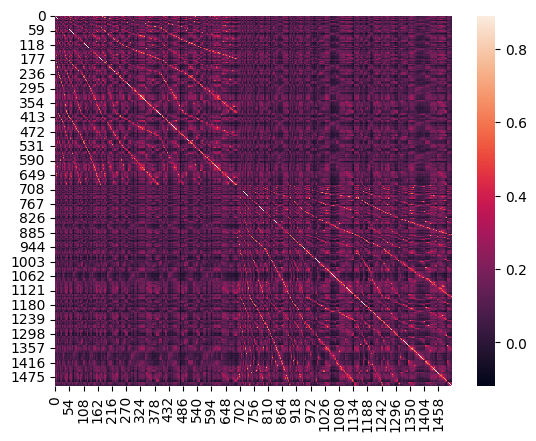

In [ ]:
sns.heatmap(cm_NPC)

In [148]:
n_components = 6
sparsity = 0.9
sparsity_name = str(sparsity).replace('.', '')
print(f'start fitting gradintes now, {cm_type}')

gm = GradientMaps(n_components=n_components) # defaults: approacch = 'dm', kernel = None
gm.fit(cm_NPC, sparsity=sparsity)
print(f'finished sub-{sub}: gradients generated')
np.save(op.join(bids_folder, f'derivatives/gradients/gradients_av-NPCmask-{cm_type}_sparsity-{sparsity_name}_group-All.npy'),gm.gradients_ )
np.save(op.join(bids_folder, f'derivatives/gradients/lambdas_av-NPCmask-{cm_type}_sparsity-{sparsity_name}_group-All.npy'),gm.lambdas_ )

# carefull... GM fitting is not deterministic, hence the result changes everytime 
# (and using this average then as a reference for alignment of ind. subjects is problematic )

start fitting gradintes now, cm-subset
finished sub-All: gradients generated


/home/ubuntu/miniconda3/envs/numrefields/lib/python3.10/site-packages/brainspace-0.1.4-py3.10.egg/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


In [179]:
gms_NPC = gm.gradients_

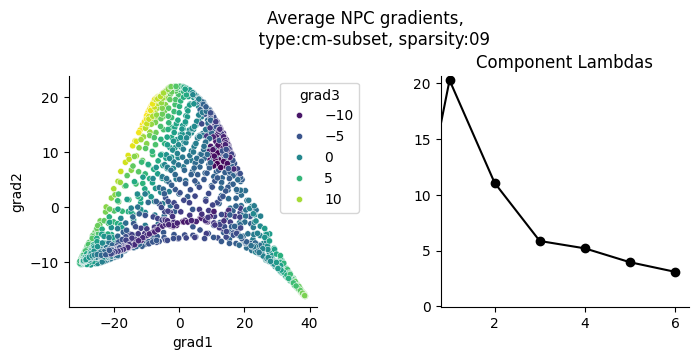

In [180]:
import seaborn as sns

df = pd.DataFrame(gms_NPC, columns=[f'grad{i+1}' for i in range(n_components)])

fig, axs = plt.subplots(1, 2, figsize=(8,3)) #, facecolor='white', constrained_layout=True)
sub = 'All'
sns.scatterplot(df, x='grad1', y='grad2',hue='grad3',palette='viridis', s=20, legend=True,ax=axs[0]) #,ax=axs[0]  # hue='grad4',palette='jet',
axs[0].set_title('')
axs[0].legend(loc='best', bbox_to_anchor=(0.7, 0.5, 0.5, 0.5), title='grad3') # loc='best', 
sns.despine()

vals = np.hstack((0,gm.lambdas_))
#ax.semilogx(vals, marker='o', mfc='k', mec='k', linestyle='-', color='k')
axs[1].plot(vals, marker='o', mfc='k', mec='k', linestyle='-', color='k')
axs[1].set(ylim=[-0.025,np.max(vals)+0.4],title=f'Component Lambdas') # )
axs[1].set_xlim(xmin=0.8)

fig.suptitle(f'Average NPC gradients, \n  type:{cm_type}, sparsity:{sparsity}',y=1.1)
fig.subplots_adjust(wspace=0.5)

### Load in and plot

In [153]:
sub = 'All'
cm_type = 'cm-subset'##'covariance'
sparsity_name = '09'
#spec = f'onlyNPC-{cor_type}_sparsity-{sparsity}'
gms_NPC = np.load(op.join(bids_folder, f'derivatives/gradients/gradients_av-NPCmask-{cm_type}_sparsity-{sparsity_name}_group-All.npy'))

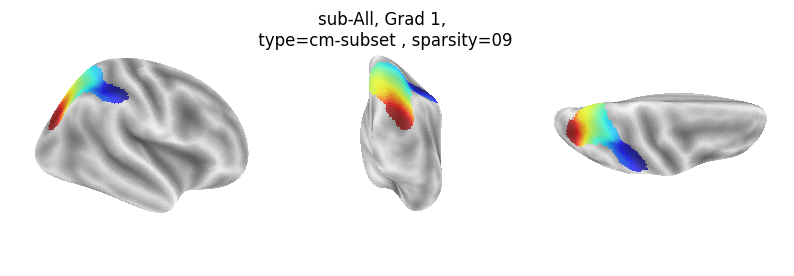

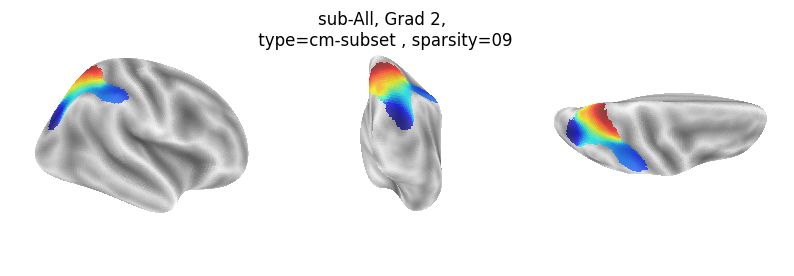

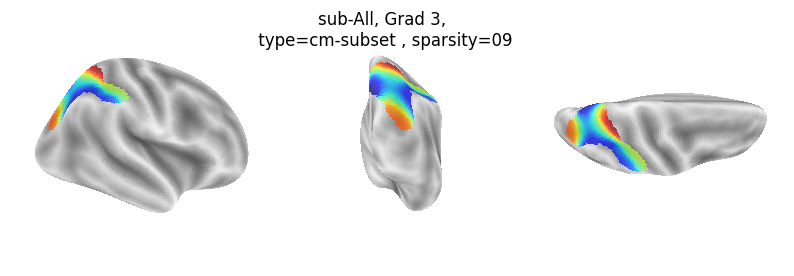

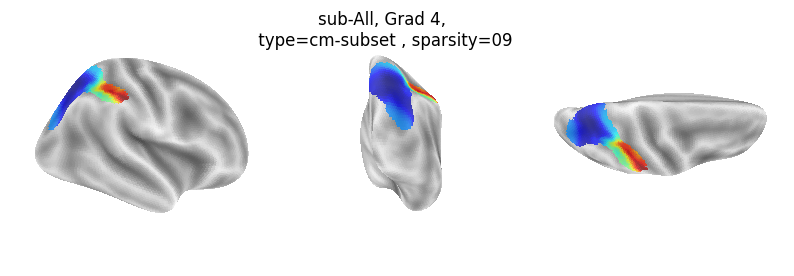

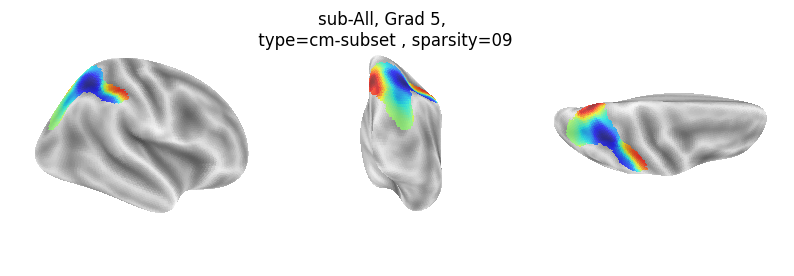

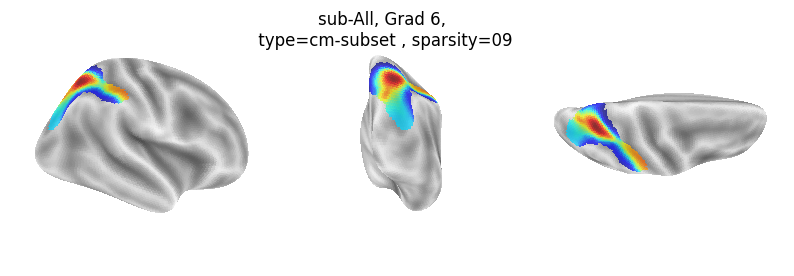

In [154]:
# np.shape(gms_NPC) --> (1510, 6)

views = ['medial','posterior','dorsal']
#n_components = 4

for n_grad in range(n_components):
    map = np.full(np.shape(mask), np.nan)#  np.zeros(np.shape(mask)) # 
    map[np.bool_(nprf_r2)] = gms_NPC.T[n_grad,:]
    gms = np.split(map,2) # for i, hemi in enumerate(['L', 'R']): --> left first
    gm_r = gms[1]# right    
    
    figure, axes = plt.subplots(nrows=1, ncols=len(views),figsize = (10,5), subplot_kw=dict(projection='3d'))
    for i,view in enumerate(views):
        nplt.plot_surf(surf_mesh= fsaverage.infl_right, surf_map= gm_r, # infl_right # pial_right
                view= view,cmap='jet', colorbar=False, 
                bg_map=fsaverage.sulc_right, bg_on_data=True,darkness=0.7, axes=axes[i]) 
    figure.suptitle(f'sub-{sub}, Grad {n_grad+1}, \n type={cm_type} , sparsity={sparsity} ', y=0.75)
    figure.subplots_adjust(wspace=0.01)



Text(0.5, 1.0, 'All, \n Component Lambdas')

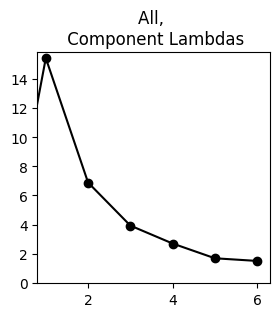

In [ ]:
lambdas = np.load(op.join(bids_folder, f'derivatives/gradients/lambdas_av-NPCmask-{cm_type}_group-All.npy'))
#lambdas = gm.lambdas_
fig, (ax) = plt.subplots(1,1, figsize=(3,3), facecolor='white')
vals = lambdas #/ np.sum(lam)
vals = np.hstack((0,vals))
ax.plot(vals, marker='o', mfc='k', mec='k', linestyle='-', color='k')
ax.set_ylim([-0.025,np.max(vals)+0.4])
ax.set_xlim(xmin=0.8)
ax.set_title(f'{sub}, \n Component Lambdas') # 

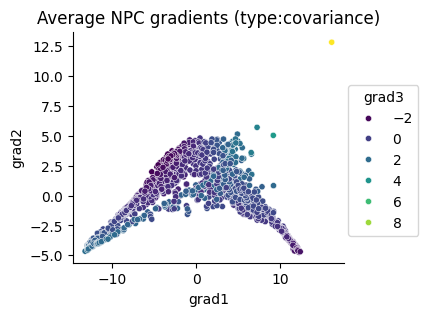

In [ ]:
import seaborn as sns

df = pd.DataFrame(gms_NPC, columns=[f'grad{i+1}' for i in range(n_components)])

fig, axes = plt.subplots(1, 1, figsize=(3.5,3)) #, facecolor='white', constrained_layout=True)
sub = 'All'
cm_type = 'covariance'
sns.scatterplot(df, x='grad1', y='grad2',hue='grad3',palette='viridis', s=20, legend=True,ax=axes) #,ax=axs[0]  # hue='grad4',palette='jet',
axes.set_title(f'Average NPC gradients (type:{cm_type})')
axes.legend(bbox_to_anchor=(0.8, 0.3, 0.5, 0.5), title='grad3') # loc='best', 
sns.despine()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(df['grad1'], df['grad2'], df['grad3'], cmap='viridis', c=df['grad4'], s = 20)
ax.set_xlabel('grad 1')
ax.set_ylabel('grad 2')
ax.set_zlabel('grad 3')

# movable 3D plot: import plotly.graph_objects as go

## Between group statistics (on subject NPC-GMs)

In [192]:
## Group differences via TTest on ind. grad loadings
from scipy.stats import ttest_ind

cor_type = 'covariance' # 'cm-subset'##
sparsity = '09'
spec = f'onlyNPC-{cor_type}' #_sparsity-{sparsity}' # f'onlyNPC-{cor_type}_sparsity-{sparsity}'
resolution ='vertex'

n_gradients = 6
gms_aligned = {f'g{i+1}': [] for i in range(n_gradients)}
for sub in subList:
    source_folder_gm = op.join(bids_folder, 'derivatives', 'gradients', f'sub-{sub}')
    gm_aligned = np.load(op.join(source_folder_gm, f'sub-{sub}_g-aligned_{spec}.npy')).T
    for i in range(n_gradients):
        gms_aligned[f'g{i+1}'].append(gm_aligned[i, :])

sub_array = np.array([int(i) for i in subList])
dfs = []
for i in range(n_gradients):
    gradient_df = pd.DataFrame(gms_aligned[f'g{i+1}'], index=sub_array)
    gradient_df.index.name = 'subject'
    gradient_df = gradient_df.join(group_list).set_index('group', append=True)
    gradient_df['n_gradient'] = i + 1
    dfs.append(gradient_df.set_index('n_gradient', append=True))

df_gms = pd.concat(dfs).sort_index(level='n_gradient')

In [193]:
from statsmodels.stats.multitest import multipletests

n_grad = 1

tmp = df_gms.xs(n_grad,0,'n_gradient')
group_0 = tmp.xs(0,0,'group')
group_1 = tmp.xs(1,0,'group')

t_stats, p_values = ttest_ind(group_0, group_1, axis=0, equal_var=False)
corrected_p_values = multipletests(p_values, method='fdr_bh')[1] 
print(len(p_values))

1510


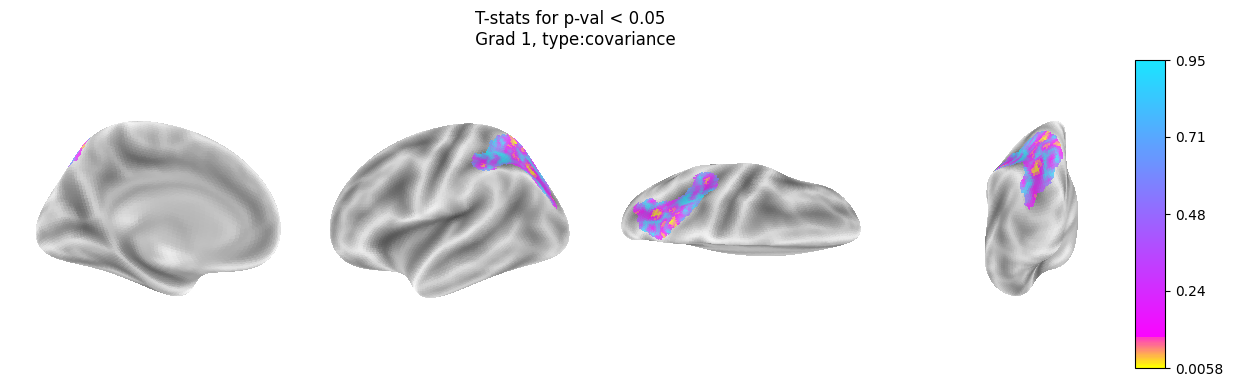

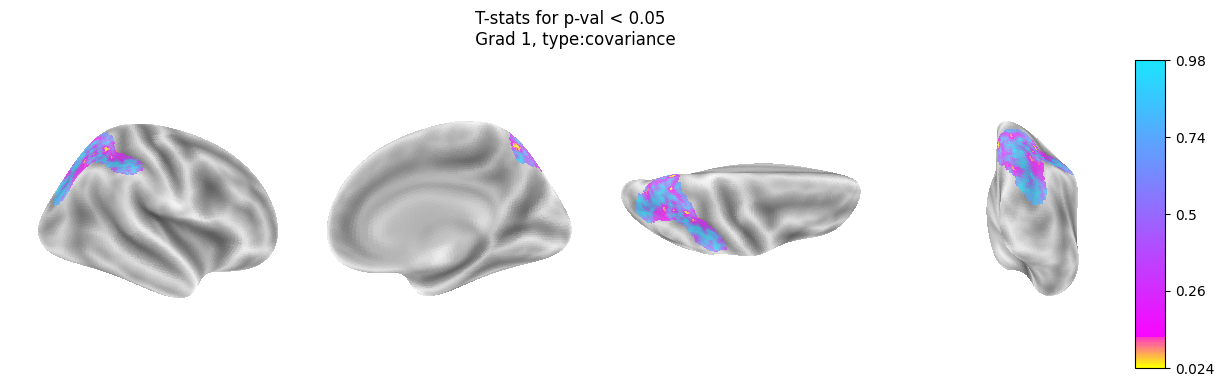

In [196]:
from brainspace.utils.parcellation import map_to_labels
from utils_02 import get_pval_colormap
pval_cmap = get_pval_colormap()
views = ['medial','lateral','dorsal','posterior']

stats_fsav5 = p_values

for i, hemi in enumerate(['L','R']):
    map = np.full(np.shape(mask), np.nan)#  np.zeros(np.shape(mask)) # 
    map[np.bool_(nprf_r2)] = stats_fsav5
    gms = np.split(map,2) # for i, hemi in enumerate(['L', 'R']): --> left first
    gm_hemi = gms[i]# right    

    surf_mesh = fsaverage.infl_right if hemi =='R' else fsaverage.infl_left
    bg_map = fsaverage.sulc_right if hemi =='R' else fsaverage.sulc_left

    figure, axes = plt.subplots(nrows=1, ncols=len(views),figsize = (15,8), subplot_kw=dict(projection='3d'))
    for i,view in enumerate(views):
        colbar = True if view == 'posterior' else False
        nplt.plot_surf(surf_mesh=surf_mesh , surf_map= gm_hemi, # infl_right # pial_right
                view= view,cmap=pval_cmap, colorbar=colbar, #title=f'sub-{sub}, grad {n_grad+1}',
                bg_map=bg_map, bg_on_data=True,darkness=0.7, axes=axes[i]) 
    figure.subplots_adjust(wspace=0.01)
    figure.suptitle(f'T-stats for p-val < 0.05 \n Grad {n_grad}, type:{cor_type}', y=0.75)

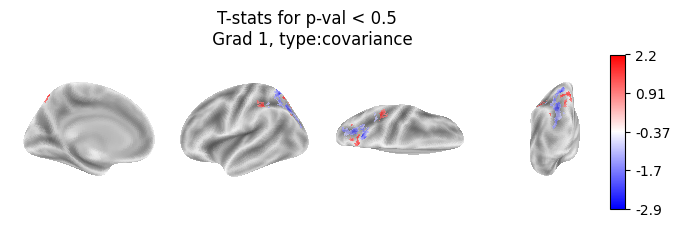

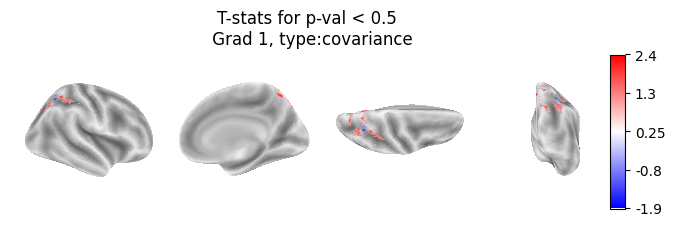

In [197]:
tstat_cmap = 'bwr'
views = ['medial','lateral','dorsal','posterior']
p_threshold = 0.5
stats_fsav5 = t_stats
stats_fsav5[p_values > p_threshold] = np.nan

for i, hemi in enumerate(['L','R']):
    map = np.full(np.shape(mask), np.nan)#  np.zeros(np.shape(mask)) # 
    map[np.bool_(nprf_r2)] = stats_fsav5
    gms = np.split(map,2) # for i, hemi in enumerate(['L', 'R']): --> left first
    gm_hemi = gms[i]# right    

    surf_mesh = fsaverage.infl_right if hemi =='R' else fsaverage.infl_left
    bg_map = fsaverage.sulc_right if hemi =='R' else fsaverage.sulc_left
    figure, axes = plt.subplots(nrows=1, ncols=len(views),figsize = (8,4), subplot_kw=dict(projection='3d'))
    for i,view in enumerate(views):
        colbar = True if view == 'posterior' else False
        nplt.plot_surf(surf_mesh=surf_mesh , surf_map= gm_hemi, # infl_right # pial_right
                view= view,cmap=tstat_cmap, colorbar=colbar, #title=f'sub-{sub}, grad {n_grad+1}',
                bg_map=bg_map, bg_on_data=True,darkness=0.7, axes=axes[i]) 
    figure.subplots_adjust(wspace=0.01)
    figure.suptitle(f'T-stats for p-val < {p_threshold} \n Grad {n_grad}, type:{cor_type}', y=0.8)

# observed: 


### Dispersion (!?) & Eccentricity 


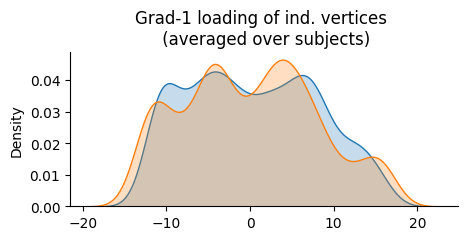

In [198]:
n_grad = 1
tmp = df_gms.xs(n_grad,0,'n_gradient')
group_0 = tmp.xs(0,0,'group').mean() # across subjects! 
group_1 = tmp.xs(1,0,'group').mean()

figure, axes = plt.subplots(1, 1,figsize = (5,2))
sns.kdeplot(group_0, ax=axes, fill=True)
sns.kdeplot(group_1, ax=axes, fill=True)
axes.set(title=f'Grad-{n_grad} loading of ind. vertices \n (averaged over subjects)')
sns.despine()


/home/ubuntu/miniconda3/envs/numrefields/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 12.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


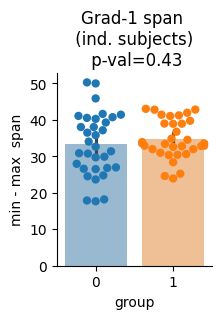

In [178]:
# Gradient span? 
n_grad = 1
tmp = df_gms.xs(n_grad, level='n_gradient', drop_level=True) # 
tmp = tmp.max(axis=1) - tmp.min(axis=1) # across vertices! 
#tmp = tmp.std(axis=1) # across vertices! 
#tmp = tmp.drop(tmp.index[np.where(tmp == tmp.max())[0][0]]) # remove outlier ! (42, 1)

figure, axes = plt.subplots(1, 1,figsize = (2,2.5))
sns.barplot(data=tmp.reset_index(), x ='group', hue='group',y=0, alpha=0.5,legend=False)
sns.swarmplot(data=tmp.reset_index(),  x ='group', hue='group',y=0, size=6,legend=False)
t_stats, p_values = ttest_ind(tmp.xs(0,0,'group'), tmp.xs(1,0,'group'), axis=0, equal_var=False)
p_val = np.round(p_values,3)

axes.set(title=f'Grad-{n_grad} span \n (ind. subjects) \n p-val={p_val}',ylabel='min - max  span')
sns.despine()


In [160]:
# Eccentricity

grad1 = df_gms.xs(1, level='n_gradient', drop_level=True)
grad2 = df_gms.xs(2, level='n_gradient', drop_level=True)
grad3 = df_gms.xs(2, level='n_gradient', drop_level=True)

eccentricity = np.sqrt(grad1.values**2 + grad2.values**2 + grad3.values**2)
eccentricity_df = pd.DataFrame(eccentricity, index=grad1.index, columns=df_gms.columns)


p-val=0.3222965356827783, T-stat=0.9899119931517685
mean group 0: 10.897364236232141, mean group 1: 10.775361177820084,
median group 0: 10.26612019601792, median group 1: 10.089157463565655,


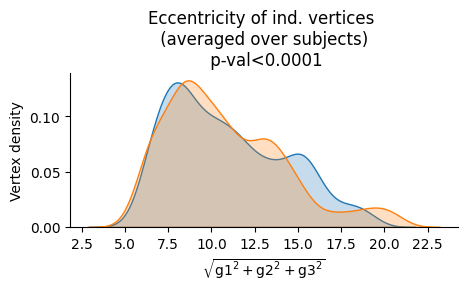

In [161]:
tmp = eccentricity_df
group_0 = tmp.xs(0,0,'group').mean() # across subjects! 
group_1 = tmp.xs(1,0,'group').mean()
group_1

figure, axes = plt.subplots(1, 1,figsize = (5,2))
sns.kdeplot(group_0, ax=axes, fill=True)
sns.kdeplot(group_1, ax=axes, fill=True)
axes.set(title=f'Eccentricity of ind. vertices \n (averaged over subjects)')
sns.despine()

t_stats, p_values = ttest_ind(group_0, group_1, axis=0, equal_var=False)
p_val = np.round(p_values,4)
axes.set(title=f'Eccentricity of ind. vertices \n (averaged over subjects) \n p-val<0.0001', 
            xlabel=r'$\sqrt{\mathrm{g1}^2 + \mathrm{g2}^2 + \mathrm{g3}^2}$',
            ylabel = 'Vertex density')
sns.despine()

print(f'p-val={p_values}, ' + f'T-stat={t_stats}')
print(f'mean group 0: {np.mean(group_0)}, ' + f'mean group 1: {np.mean(group_1)},')
print(f'median group 0: {np.median(group_0)}, ' + f'median group 1: {np.median(group_1)},')

## on group average dyscalculics have higher eccentricity!
# now try subject wise statistics

p-val=0.8385552196954242, T-stat=0.20477692276162135
mean group 0: 10.897364236232141, mean group 1: 10.775361177820084,
median group 0: 10.26612019601792, median group 1: 10.089157463565655,


/home/ubuntu/miniconda3/envs/numrefields/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 12.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


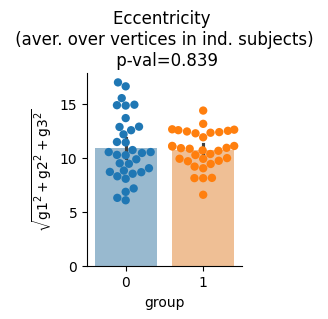

In [162]:
tmp = eccentricity_df.mean(axis=1)
figure, axes = plt.subplots(1, 1,figsize = (2,2.5))
sns.barplot(data=tmp.reset_index(), x ='group', hue='group',y=0, alpha=0.5,legend=False)
sns.swarmplot(data=tmp.reset_index(),  x ='group', hue='group',y=0, size=6,legend=False)
sns.despine()

t_stats, p_values = ttest_ind(tmp.xs(0,0,'group'), tmp.xs(1,0,'group'), axis=0, equal_var=False)
p_val = np.round(p_values,3)

axes.set(ylabel=r'$\sqrt{\mathrm{g1}^2 + \mathrm{g2}^2 + \mathrm{g3}^2}$', title=f'Eccentricity \n (aver. over vertices in ind. subjects) \n p-val={p_val}') #')# ,ylim=(4,31)

print(f'p-val={p_values}, ' + f'T-stat={t_stats}')

print(f'mean group 0: {np.mean(group_0)}, ' + f'mean group 1: {np.mean(group_1)},')
print(f'median group 0: {np.median(group_0)}, ' + f'median group 1: {np.median(group_1)},')


## Addtional

finished sub-01: gradients generated


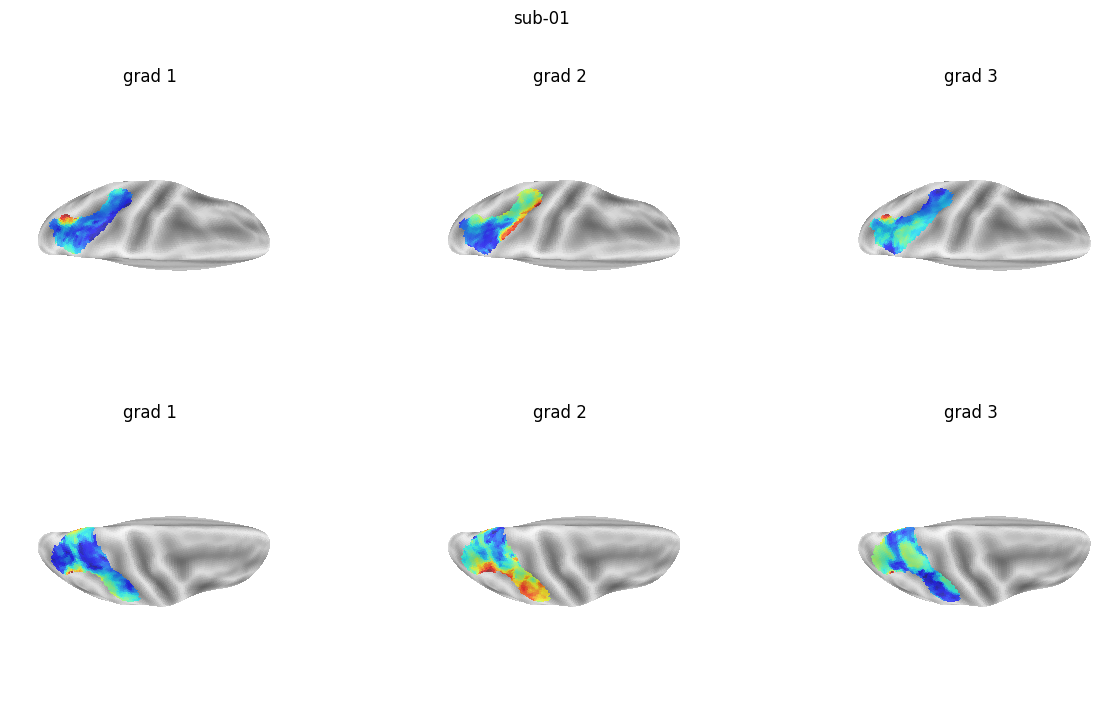

In [ ]:
# example, loop over subs in 'loop_NPCmask-gradient_plots.py' executabel in terminal (tmux)

sub= '01'
cm_file = op.join(bids_folder, 'derivatives', 'correlation_matrices', f'sub-{sub}_unfiltered.npy')
cm = np.load(cm_file)
cm_NPC = cm[np.bool_(nprf_r2_mask),:]
cm_NPC_cov = cm_NPC.dot(cm_NPC.T) # covariance matrix

gm = GradientMaps(n_components=3) # defaults: approacch = 'dm', kernel = None
gm.fit(cm_NPC_cov)
print(f'finished sub-{sub}: gradients generated')

figure, axes = plt.subplots(nrows=2, ncols=3,figsize = (15,8), subplot_kw=dict(projection='3d'))
for n_grad in range(3):
    map = np.full(np.shape(mask), np.nan) #  np.zeros(np.shape(mask)) # 
    map[np.bool_(nprf_r2)] = gm.gradients_.T[n_grad,:]
    gms = np.split(map,2) 
    
    for n_hemi, hemi in enumerate(['L','R']):
        gm_ = gms[n_hemi]# right    
        surf_mesh = fsaverage.infl_left if hemi == 'L' else fsaverage.infl_right
        bg_map = fsaverage.sulc_left  if hemi == 'L' else fsaverage.sulc_right

        nplt.plot_surf(surf_mesh= surf_mesh, surf_map= gm_, 
                view= view,cmap='jet', colorbar=False, title=f'grad {n_grad+1}',
                bg_map=bg_map, bg_on_data=True,darkness=0.7, axes=axes[n_hemi, n_grad]) 
            
figure.suptitle(f'sub-{sub}')
plt.savefig(op.join(plot_folder, f'sub-{sub}_NPCmask-gradient.png'),bbox_inches='tight', dpi=300)

In [3]:
from nipype.interfaces.freesurfer import SurfaceTransform # needs the fsaverage & fsaverage5 in ..derivatives/freesurfer folder!
source_space = 'fsaverage'
target_space = 'fsaverage5'

for hemi in ['L', 'R']:
    fs_hemi= 'lh' if hemi == 'L' else 'rh'
    in_file = op.join(bids_folder, 'derivatives/surface_masks', f'desc-NPC_{hemi}_space-{source_space}_hemi-{fs_hemi}.label.gii')
    sxfm = SurfaceTransform(subjects_dir=op.join(bids_folder,'derivatives','freesurfer'))
    sxfm.inputs.source_file = in_file
    sxfm.inputs.out_file =  in_file.replace(source_space, target_space)
    sxfm.inputs.source_subject = source_space 
    sxfm.inputs.target_subject = target_space 
    sxfm.inputs.hemi = fs_hemi

    r = sxfm.run()

241126-12:58:32,439 nipype.interface INFO:
	 stderr 2024-11-26T12:58:32.439395:** DA[0] has coordsys with intent NIFTI_INTENT_NONE (should be NIFTI_INTENT_POINTSET)
241126-12:58:33,115 nipype.interface INFO:
	 stdout 2024-11-26T12:58:33.115000:
241126-12:58:33,115 nipype.interface INFO:
	 stdout 2024-11-26T12:58:33.115000:7.3.2
241126-12:58:33,116 nipype.interface INFO:
	 stdout 2024-11-26T12:58:33.115000:
241126-12:58:33,116 nipype.interface INFO:
	 stdout 2024-11-26T12:58:33.115000:setenv SUBJECTS_DIR /mnt_03/ds-dnumrisk/derivatives/freesurfer
241126-12:58:33,117 nipype.interface INFO:
	 stdout 2024-11-26T12:58:33.115000:cd /home/ubuntu/git/numrisk/numrisk/fmri_analysis/gradients
241126-12:58:33,117 nipype.interface INFO:
	 stdout 2024-11-26T12:58:33.115000:mri_surf2surf --hemi lh --tval /mnt_03/ds-dnumrisk/derivatives/surface_masks/desc-NPC_L_space-fsaverage5_hemi-lh.label.gii --sval /mnt_03/ds-dnumrisk/derivatives/surface_masks/desc-NPC_L_space-fsaverage_hemi-lh.label.gii --srcsubj

In [ ]:
import seaborn as sns
sns.heatmap(cm_NPC_cov)

In [21]:
subList = [f[4:6] for f in listdir(op.join(bids_folder)) if f[0:4] == 'sub-' and len(f)==6]

for sub in subList:
    # Define the source folder for each subject
    source_folder_gm = op.join(bids_folder, 'derivatives', 'gradients', f'sub-{sub}')
    
    # Check if the folder exists
    if not op.exists(source_folder_gm):
        print(f"Source folder does not exist for sub-{sub}: {source_folder_gm}")
        continue
    
    # Iterate over files in the folder
    for file_name in os.listdir(source_folder_gm):
        # Check if 'g-aligend' is in the file name
        if 'g-aligend' in file_name:
            # Create the new file name
            new_file_name = file_name.replace('g-aligend', 'g-aligned')
            # Create full paths
            old_file_path = op.join(source_folder_gm, file_name)
            new_file_path = op.join(source_folder_gm, new_file_name)
            # Rename the file
            os.rename(old_file_path, new_file_path)
            print(f"Renamed: {old_file_path} -> {new_file_path}")

Renamed: /mnt_03/ds-dnumrisk/derivatives/gradients/sub-38/sub-38_g-aligend_onlyNPC-covariance.npy -> /mnt_03/ds-dnumrisk/derivatives/gradients/sub-38/sub-38_g-aligned_onlyNPC-covariance.npy
Renamed: /mnt_03/ds-dnumrisk/derivatives/gradients/sub-48/sub-48_g-aligend_onlyNPC-covariance.npy -> /mnt_03/ds-dnumrisk/derivatives/gradients/sub-48/sub-48_g-aligned_onlyNPC-covariance.npy
